In [0]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from numpy import newaxis
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
%matplotlib inline

Using TensorFlow backend.


In [0]:
torch.manual_seed(1337)
np.random.seed(1337)

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    torch.cuda.manual_seed(1337)
else:
    DEVICE = None

In [0]:
DEVICE

'cuda:0'

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data

In [0]:
data_path = '/content/drive/My Drive/Diplom/data'

In [0]:
df_train = pd.read_csv(data_path + '/train.csv', index_col="id")
df_test = pd.read_csv(data_path + '/test.csv', index_col="id")
df_test_ans = pd.read_csv(data_path + "/ans.csv", index_col="id")
df_test_ans['sat_id'] = df_test['sat_id']
df_pred_sgp4 = pd.read_csv(data_path + "/pred_sgp.csv", index_col="id")

n_sat = len(pd.unique(df_train["sat_id"]))

In [0]:
df_train[df_train['sat_id'] == 0].shape[0]

215

In [0]:
a = []
for n in range(n_sat):
    a.append(df_train[df_train['sat_id'] == n].shape[0])

(array([158., 136., 124.,  83.,  42.,  32.,  15.,   6.,   3.,   1.]),
 array([ 100. ,  293.9,  487.8,  681.7,  875.6, 1069.5, 1263.4, 1457.3,
        1651.2, 1845.1, 2039. ]),
 <a list of 10 Patch objects>)

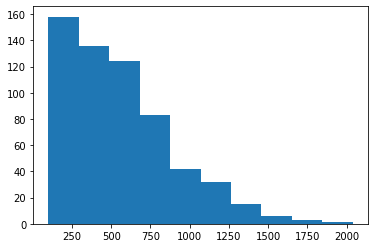

In [0]:
plt.hist(a)

In [0]:
sc = MinMaxScaler(feature_range=(0,1))

In [0]:
data_path = '/content/drive/My Drive/Diplom/data'
df_train = pd.read_csv(data_path + '/train.csv', index_col="id")
df_test = pd.read_csv(data_path + '/test.csv', index_col="id")
df_test_ans = pd.read_csv(data_path + "/ans.csv", index_col="id")
df_test_ans['sat_id'] = df_test['sat_id']
df_pred_sgp4 = pd.read_csv(data_path + "/pred_sgp.csv", index_col="id")

n_sat = len(pd.unique(df_train["sat_id"]))
sc = MinMaxScaler(feature_range=(0,1))

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01T00:00:00.000,0,-42610.746108,-950.947579,-150.480874,-0.053824,2.819207,-2.574694,-42240.798364,-174.838890,-879.668497,0.003675,2.810373,-2.616507
1,2014-01-01T03:27:39.104,0,-28572.436555,30683.997692,-28690.937467,2.005508,2.052520,-1.825483,-27464.918026,31096.520145,-29629.836338,2.045653,2.006299,-1.817265
2,2014-01-01T06:55:18.208,0,162.172770,49535.021870,-45208.609618,2.429630,1.035764,-0.887060,1527.795437,49447.308248,-45994.112453,2.431892,1.001504,-0.872049
3,2014-01-01T10:22:57.312,0,29688.627324,58121.236575,-52335.405494,2.270135,0.396228,-0.306936,31011.763016,57726.886540,-52965.113733,2.259802,0.378083,-0.295799
4,2014-01-01T13:50:36.416,0,56271.589069,60415.811680,-53787.597409,1.990739,0.001809,0.046556,57461.761250,59878.934228,-54303.123793,1.977595,-0.005517,0.054374


In [0]:
dates = df_train.epoch.values
day = set()
for d in dates:
    day.add(d.split('-')[2][:2])
day

{'01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31'}

In [0]:
df_test.head()

,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,
215,0,2014-02-01T00:05:07.344,-28099.394464,-31393.873066,27879.580116,-2.048926,1.980606,-1.879962
216,0,2014-02-01T03:32:46.448,-42644.222149,-288.393217,-1087.275407,0.015348,2.814050,-2.577676
217,0,2014-02-01T07:00:25.552,-27979.382752,31096.467597,-29369.026222,2.033737,2.029262,-1.794169
218,0,2014-02-01T10:28:04.656,896.126549,49712.580025,-45492.481646,2.433120,1.022877,-0.859440
219,0,2014-02-01T13:55:43.760,30391.384369,58185.560870,-52301.500238,2.267209,0.390206,-0.285250


In [0]:
from tqdm import tqdm

In [0]:
from tqdm import tqdm
# features columns 
feature_cols = ["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]

# target variables columns 
target_cols = ["x", "y", "z", "Vx", "Vy", "Vz"]

# RNN

In [0]:
class LSTM_bases(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(6, 6)
        self.lin = nn.Linear(6, 6)
    
    def forward(self, X):
        h = (torch.randn(1, 1, 6), torch.randn(1, 1, 6))
        outputs = []
        for x in X:
            out, h = self.lstm(x.view(1, 1, -1).float(), h)
            out1 = self.lin(out)
            outputs.append(out1)
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [0]:
class RNN_bases(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.RNN(6, 6)
        self.lin = nn.Linear(6, 6)
    
    def forward(self, X):
        h = torch.randn(1, 1, 6)
        outputs = []
        for x in X:
            out, h = self.lstm(x.view(1, 1, -1).float(), h)
            out1 = self.lin(out)
            outputs.append(out1)
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [0]:
class GRU_bases(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.GRU(6, 6)
        self.lin = nn.Linear(6, 6)
    
    def forward(self, X):
        h = torch.randn(1, 1, 6)
        outputs = []
        for x in X:
            out, h = self.lstm(x.view(1, 1, -1).float(), h)
            out1 = self.lin(out)
            outputs.append(out1)
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [0]:
def train_epoch(model, optimizer):
    loss_log = []
    model.train()
    for i, data in enumerate(X_train):
        target = y_train[i]
        target = torch.tensor(target).float()
        data = torch.tensor(data)
        optimizer.zero_grad()
        output = model(data)
        loss_function = nn.MSELoss()        
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def plot_history(train_history, title='loss'):
    clear_output()
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss = train_epoch(model, opt)
        train_log.extend(train_loss)
        plot_history(train_log)

In [0]:
def getX(df, feature_cols, target_cols):
    X_train = []
    y_train = []
    for i in range(n_sat):
        x = df[df['sat_id'] == i].sort_values(['epoch'])[feature_cols].to_numpy()
        y = df[df['sat_id'] == i].sort_values(['epoch'])[target_cols].to_numpy()
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        X_train.append(x)
        y_train.append(y)
    return X_train, y_train

In [0]:
X_train, y_train = getX(df_train, feature_cols, target_cols)

In [0]:
X_train[0].shape

(215, 1, 6)

In [0]:
len(X_train)

600

In [0]:
y_train[0].shape

(215, 1, 6)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%%time
modelL = LSTM_bases()
modelL = modelL.to(DEVICE)
opt = torch.optim.Adam(modelL.parameters(), lr=0.0005)

CPU times: user 1.98 s, sys: 771 ms, total: 2.75 s
Wall time: 2.76 s


In [0]:
train(modelL, opt, 10)

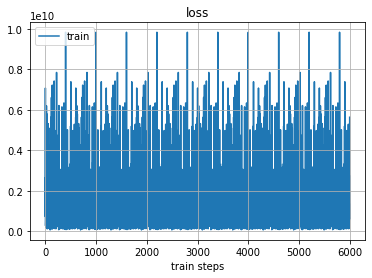

In [0]:
modelR = RNN_bases()
opt = torch.optim.Adam(modelR.parameters(), lr=0.0005)
train(modelR, opt, 10)

In [0]:
%%time
modelG = GRU_bases()
opt = torch.optim.Adam(modelG.parameters(), lr=0.0005)

CPU times: user 1.63 ms, sys: 0 ns, total: 1.63 ms
Wall time: 1.46 ms


In [0]:
#modelG = modelG.to(DEVICE)

In [0]:
train(modelG, opt, 100)

In [0]:
def test(model, name):
    pred = pd.DataFrame(columns=target_cols, index=df_test.index)
    X_test = df_test[feature_cols].values
    pred["sat_id"] = df_test["sat_id"]
    p = []
    for x in X_test:
        model.eval()
        p.append(model(torch.tensor(x).float().view(1, -1).view(1, 1, -1)).detach().numpy())
    p = np.array(p)
    p = p.reshape(302458, 6)
    for i, col in enumerate(target_cols):
        pred[col] = p[:, i]
    print_metrics(name, pred)

In [0]:
test(modelR, 'RNN')


RNN

IDAO score:  11.080449413655803
SMAPE IDAO:  0.889195505863442
SMAPE new:   1.7780232254877126


In [0]:
test(modelL, 'LSTM')


LSTM

IDAO score:  9.343313382257957
SMAPE IDAO:  0.9065668661774204
SMAPE new:   1.819967649391191


In [0]:
test(modelG, 'GRU')


GRU

IDAO score:  11.492832926745233
SMAPE IDAO:  0.8850716707325477
SMAPE new:   1.7595817874755963


# IDAO

In [0]:
pred_idao = pd.read_csv(data_path + '/sub_idao_example.csv', index_col='id')

# Metrics

In [0]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from numpy.linalg import norm
import pandas as pd

def smape_idao(pred, ans):
    pred = pred.values
    ans = ans.values
    return np.mean(np.abs(pred - ans) / (np.abs(pred) + np.abs(ans)))

def idao_score(pred, ans):
    return 100 * (1 - smape_idao(pred, ans))

def smape_new_vector_norm(pred, ans, av_score=True):
    assert set(ans.columns) == {'y', 'Vy', 'x', 'z', 'Vx', 'sat_id', 'Vz'}
    for c in ["x", "y", "z", "Vx", "Vy", "Vz"]:
        assert c in pred.columns
    assert (ans.index == pred.index).all()
    scores = []
    if not av_score:
        r_losses = v_losses = []
    for sat_id in pd.unique(ans["sat_id"]):
        idxs = (ans["sat_id"] == sat_id).values
        p = pred.loc[idxs, ["x", "y", "z", "Vx", "Vy", "Vz"]].values.astype("float")
        a = ans.loc[idxs, ["x", "y", "z", "Vx", "Vy", "Vz"]].values.astype("float")
        loss = p - a
        # coordinates
        r_loss = norm(loss[:, :3], axis=1) / (norm(p[:, :3], axis=1) + norm(a[:, :3], axis=1))
        r_loss = np.mean(r_loss)
        # velocities
        v_loss = norm(loss[:, 3:], axis=1) / (norm(p[:, 3:], axis=1) + norm(a[:, 3:], axis=1))     
        v_loss = np.mean(v_loss)
        # score
        scores.append(r_loss + v_loss)
        if not av_score:
            r_losses.append(r_loss)            
            v_losses.append(v_loss)
    if av_score:
        return np.mean(scores)
    else:
        return np.array(scores), np.array(r_losses), np.array(v_losses)

def mahalanobis_distance(pred, ans):
    # TODO: не ясно откуда берется ковариационная матрица
    scores = []
    for sat_id in pd.unique(ans["sat_id"]):
        idxs = (ans["sat_id"] == sat_id).values
        p = pred.loc[idxs, ["x", "y", "z", "Vx", "Vy", "Vz"]]
        a = ans.loc[idxs, ["x", "y", "z", "Vx", "Vy", "Vz"]]
        # coordinates
        r_loss = []
        for coord in ['x', 'y', 'z']:
            p_coord = p[coord].values.astype("float")
            a_coord = a[coord].values.astype("float")
            cov = np.cov(np.stack([p_coord, a_coord], axis=1))
            r_loss.append(mahalanobis(p_coord, a_coord, cov))
        # score
        scores.append(r_loss)
    return np.mean(scores)


In [0]:
def print_metrics(model_name, pred):
    print(f"\n{model_name}\n")
    print(f"IDAO score:  {idao_score(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE IDAO:  {smape_idao(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE new:   {smape_new_vector_norm(pred, df_test_ans)}")    
#     print(f"Mahalanobis: {mahalanobis_distance(pred, df_test_ans)}")

In [0]:
pred_sgp4 = df_pred_sgp4.rename(
    columns=dict(zip(feature_cols, target_cols)))

print_metrics("SGP4 – Total Score:", pred_sgp4)
print_metrics("LR – Total Score:", pred_lr)
print_metrics("IDAO – Total Score:", pred_idao)


SGP4 – Total Score:

IDAO score:  85.76745399276147
SMAPE IDAO:  0.14232546007238525
SMAPE new:   0.2105207081354428

LR – Total Score:

IDAO score:  91.81678353872567
SMAPE IDAO:  0.08183216461274322
SMAPE new:   0.1272771961005083

IDAO – Total Score:

IDAO score:  96.92031297743414
SMAPE IDAO:  0.030796870225658628
SMAPE new:   0.052050588061025874


Pytorch working with different length of seq

Anti crash

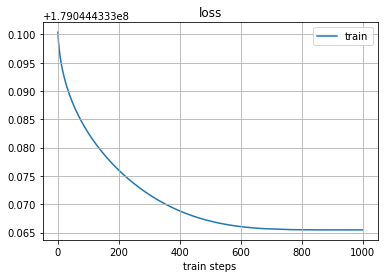



100%|██████████| 1000/1000 [19:38<00:00,  1.18s/it]


In [0]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from numpy import newaxis
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
%matplotlib inline

torch.manual_seed(1337)
np.random.seed(1337)

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    torch.cuda.manual_seed(1337)
else:
    DEVICE = None

data_path = '/content/drive/My Drive/Diplom/data'
df_train = pd.read_csv(data_path + '/train.csv', index_col="id")
df_test = pd.read_csv(data_path + '/test.csv', index_col="id")
df_test_ans = pd.read_csv(data_path + "/ans.csv", index_col="id")
df_test_ans['sat_id'] = df_test['sat_id']
df_pred_sgp4 = pd.read_csv(data_path + "/pred_sgp.csv", index_col="id")

n_sat = len(pd.unique(df_train["sat_id"]))
sc = MinMaxScaler(feature_range=(0,1))
BATCH = n_sat
from tqdm import tqdm
feature_cols = ["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]

target_cols = ["x", "y", "z", "Vx", "Vy", "Vz"]

X_lengths = []
Y_lengths = []
def data_preproc(df):
    n_sat = len(pd.unique(df["sat_id"]))
    df[feature_cols] = sc.fit_transform(df[feature_cols])
    X = []
    Y = []
    for i in range(n_sat):
        x = df[df['sat_id'] == i].sort_values(['epoch'])[feature_cols].to_numpy()
        y = df[df['sat_id'] == i].sort_values(['epoch'])[target_cols].to_numpy()
        X.append(x)
        Y.append(y)
    c = list(zip(X, Y))
    c.sort(key=lambda x: x[0].shape[0])
    X = []
    Y = []
    for x, y in c:
        X.append(x)
        Y.append(y)
    X = X[::-1]
    Y = Y[::-1]
    X_lengths = [len(sentence) for sentence in X]
    pad_token = 0
    longest_sent = max(X_lengths)
    batch_size = len(X)
    padded_X = np.ones((batch_size, longest_sent, 6)) * pad_token
    for i, x_len in enumerate(X_lengths):
        sequence = X[i]
        padded_X[i, 0:x_len] = sequence[:x_len]

    Y_lengths = [len(sentence) for sentence in Y]
    pad_token = 0
    longest_sent = max(Y_lengths)
    batch_size = len(Y)
    padded_Y = np.ones((batch_size, longest_sent, 6)) * pad_token
    for i, y_len in enumerate(Y_lengths):
        sequence = Y[i]
        padded_Y[i, 0:y_len] = sequence[:y_len]
    return padded_X, padded_Y, X_lengths, Y_lengths
X_lengths = torch.tensor(X_lengths)
Y_lengths = torch.tensor(Y_lengths)
x, y, X_lengths, Y_lengths = data_preproc(df_train)


X_lengths = torch.tensor(X_lengths)
Y_lengths = torch.tensor(Y_lengths)
X_lengths.size(), Y_lengths.size()
train_ds = TensorDataset(torch.tensor(x), torch.tensor(y))
train_dl = DataLoader(train_ds, BATCH, shuffle=False)

class SLSTM(nn.Module):
    def __init__(self, nb_layers=10, nb_lstm_units=10, embedding_dim=6, batch_size=BATCH):
        super(SLSTM, self).__init__()
        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.out_size = 6
        self.nb_lstm_layers = nb_layers

        self.__build_model()

    def __build_model(self):

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(self.nb_lstm_units, self.out_size)

    def init_hidden(self):
        hidden_a = torch.randn(self.nb_lstm_layers, self.batch_size, self.nb_lstm_units)
        hidden_b = torch.randn(self.nb_lstm_layers, self.batch_size, self.nb_lstm_units)

        hidden_a = hidden_a.cuda()
        hidden_b = hidden_b.cuda()

        hidden_a = torch.tensor(hidden_a)
        hidden_b = torch.tensor(hidden_b)

        return (hidden_a, hidden_b)

    def forward(self, X, X_lengths):
        self.hidden = self.init_hidden()
        X = X.float()
        batch_size, seq_len, _ = X.size()
        X = torch.nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True)
        X, self.hidden = self.lstm(X, self.hidden)
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        X = X.contiguous()
        X = X.view(-1, X.shape[2])
        X = self.fc(X)
        X = X.view(batch_size, X_lengths.max(), self.out_size)

        Y_hat = X
        return Y_hat

    def loss(self, Y_hat, Y, X_lengths):

        pad_token = torch.tensor([0, 0, 0, 0, 0, 0]).float().cuda()
        Y = Y.view(Y.shape[0] * Y.shape[1], 6)
        Y_hat = Y_hat.view(Y_hat.shape[0] * Y_hat.shape[1], 6)
        mask = (Y.sum(axis=1) !=0)
        Y_hat[mask] =  pad_token
        mse_loss = torch.mean((Y_hat - Y)**2)

        return mse_loss

class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
        
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

def train_epoch(model, optimizer, X_train):
    loss_log = []
    model.train()
    for i, (x_batch, y_batch) in enumerate(X_train):
        model.train()
        
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        sched.step()
        opt.zero_grad()
        out = model(x_batch, X_lengths[i*x_batch.shape[0]:min((i+1)*x_batch.shape[0], X_lengths.shape[0])])
        loss = model.loss(out, y_batch, X_lengths[i*x_batch.shape[0]:min((i+1)*x_batch.shape[0], X_lengths.shape[0])])
        loss.backward()
        opt.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def plot_history(train_history, title='loss'):
    clear_output()
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs, X_train):
    train_log = []
    for epoch in tqdm(range(n_epochs)):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss = train_epoch(model, opt, X_train)
        train_log.extend(train_loss)
        plot_history(train_log)

lr = 0.0005
iterations_per_epoch = len(train_dl)
model = SLSTM()
model.to(DEVICE)
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))
train(model, opt, 1000, train_dl)


In [0]:
df_test.head()

,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,
215,0,2014-02-01T00:05:07.344,-28099.394464,-31393.873066,27879.580116,-2.048926,1.980606,-1.879962
216,0,2014-02-01T03:32:46.448,-42644.222149,-288.393217,-1087.275407,0.015348,2.814050,-2.577676
217,0,2014-02-01T07:00:25.552,-27979.382752,31096.467597,-29369.026222,2.033737,2.029262,-1.794169
218,0,2014-02-01T10:28:04.656,896.126549,49712.580025,-45492.481646,2.433120,1.022877,-0.859440
219,0,2014-02-01T13:55:43.760,30391.384369,58185.560870,-52301.500238,2.267209,0.390206,-0.285250


In [0]:
def test_data_preproc(df):
    df[feature_cols] = sc.fit_transform(df[feature_cols])
    X = torch.tensor(df[feature_cols].values)
    X = X.view(X.shape[0], 1, 6)
    return X

In [0]:
df_test_ans.head()

,x,y,z,Vx,Vy,Vz,sat_id
id,,,,,,,
215,-30992.169683,-29136.390673,25178.674635,-1.911277,2.118534,-1.964551,0
216,-42746.725504,3114.006255,-4170.339105,0.280350,2.818395,-2.522796,0
217,-25811.740855,33700.249402,-31101.368327,2.118865,1.934959,-1.669977,0
218,3470.877327,51307.377712,-45974.857869,2.429820,0.956797,-0.781210,0
219,32802.355913,59110.422155,-52039.149952,2.244968,0.346241,-0.238677,0


In [0]:
def test(model, name, df_test):
    pred = pd.DataFrame(columns=target_cols, index=df_test.index)
    X_test = test_data_preproc(df_test)
    test_ds = TensorDataset(X_test, torch.zeros(X_test.shape))
    test_dl = DataLoader(test_ds, BATCH, shuffle=False)
    pred["sat_id"] = df_test["sat_id"]
    p = []
    for i, (x_batch, y_batch) in enumerate(test_dl):
        model.eval()
        l = torch.tensor([1 for i in range(x_batch.shape[0])])
        if x_batch.shape[0] < 600:
              break
        p.append(model(x_batch.cuda(), l).cpu().detach().numpy())
    p = np.concatenate(p, axis=0)
    p = p.reshape(302400, 6)
    p = p.tolist()
    for i in range(58):
        p.append(np.array([0, 0, 0, 0, 0, 0]))
    p = np.array(p)
    print(p.shape)
    for i, col in enumerate(target_cols):
        pred[col] = p[:, i]
    print_metrics(name, pred)

In [0]:
test(model, 'LSTM', df_test)

torch.Size([302458, 1, 6])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(302458, 6)

LSTM

IDAO score:  5.284889278373406
SMAPE IDAO:  0.9471511072162659
SMAPE new:   1.919529380417498


In [0]:
mask = (a.sum(axis=1) == 6)
mask

array([ True, False, False, False])

In [0]:
a[mask]

array([[1, 2, 3]])

In [0]:
a.shape

(4, 3)